## 기본설정 및 함수정의

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

##### 분석대상지 격자

In [2]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/09. 격자(분석대상지).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_analyze = pd.json_normalize(geojson_data['features'])
grid_analyze['geometry'] = grid_analyze['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_analyze.drop(columns="geometry.coordinates", axis=1, inplace=True)
# grid_analyze 데이터프레임을 GeoDataFrame으로 변환
grid_analyze = gpd.GeoDataFrame(grid_analyze, geometry='geometry')
grid_analyze_dict = dict(zip(grid_analyze['properties.gid'], grid_analyze['geometry']))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type']
grid_analyze = grid_analyze.drop(columns=drop_cols)

# 'properties.' 접두사 제거
grid_analyze.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in grid_analyze.columns
]

grid_analyze = grid_analyze.drop_duplicates(subset='gid', keep='first')

In [ ]:
# 맵 객체 생성 및 데이터 로드
grid_map = KeplerGl(height=1000, width=1500)
grid_map.add_data(data=grid_analyze, name="격자 데이터")

# 맵 출력 및 상세설정
grid_map

##### 행정동

In [3]:
# 송파구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_11240_2023_4Q/bnd_dong_11240_2023_4Q.shp"
songpa_gdf = gpd.read_file(shapefile_path1)
songpa_gdf = songpa_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 인천서구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_23080_2023_4Q/bnd_dong_23080_2023_4Q.shp"
incheon_seo_gdf = gpd.read_file(shapefile_path1)
incheon_seo_gdf = incheon_seo_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 성남시 수정구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31021_2023_4Q/bnd_dong_31021_2023_4Q.shp"
sungnam_soojung_gdf = gpd.read_file(shapefile_path1)
sungnam_soojung_gdf = sungnam_soojung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 성남시 중원구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31022_2023_4Q/bnd_dong_31022_2023_4Q.shp"
sungnam_jungwon_gdf = gpd.read_file(shapefile_path1)
sungnam_jungwon_gdf = sungnam_jungwon_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 성남시 분당구 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31023_2023_4Q/bnd_dong_31023_2023_4Q.shp"
sungnam_bundang_gdf = gpd.read_file(shapefile_path1)
sungnam_bundang_gdf = sungnam_bundang_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#  하남시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31180_2023_4Q/bnd_dong_31180_2023_4Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#  화성시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31240_2023_4Q/bnd_dong_31240_2023_4Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path1)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 광명시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31060_2023_4Q/bnd_dong_31060_2023_4Q.shp"
gwangmyung_gdf = gpd.read_file(shapefile_path1)
gwangmyung_gdf = gwangmyung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 시흥시 행정동 데이터
shapefile_path1 = "SBJ_2504_001/bnd_dong_31150_2023_4Q/bnd_dong_31150_2023_4Q.shp"
siheung_gdf = gpd.read_file(shapefile_path1)
siheung_gdf = siheung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#### 격자인구통계

In [4]:
respop_df = pd.read_csv('SBJ_2504_001/01. 성연령별_거주인구(격자).csv')

#grid ID 리스트 와 매핑 & respop_df 필터링
grid_id = grid_analyze['gid'].tolist() # gid는 전부 unique한 값
grid_respop = respop_df[respop_df['gid'].isin(grid_id)]
grid_respop = grid_respop.fillna(0)
grid_respop = pd.concat([grid_respop.iloc[:, :2], grid_respop.iloc[:, 2:].astype(int)], axis=1)
grid_respop['year'] = grid_respop['year'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['gbn', 'gid', 'year']
for i in range(3, len(grid_respop.columns)):
    age = f'{grid_respop.columns[i][2:4]}대' if grid_respop.columns[i][2] != '1' else f'{grid_respop.columns[i][2:5]}대'
    sex = '남' if grid_respop.columns[i][0] != 'm' else '여'
    columns.append('%s_%s'%(age, sex))
grid_respop.columns = columns
# 인구 column 생성
grid_respop['인구'] = grid_respop.iloc[:, 3:].sum(axis=1)

# 연령대별로 성별 통합
grid_respop['20대'] = grid_respop['20대_여'] + grid_respop['20대_남']
grid_respop['30대'] = grid_respop['30대_여'] + grid_respop['30대_남']
grid_respop['40대'] = grid_respop['40대_여'] + grid_respop['40대_남']
grid_respop['50대'] = grid_respop['50대_여'] + grid_respop['50대_남']
grid_respop['60대'] = grid_respop['60대_여'] + grid_respop['60대_남']
grid_respop['70대'] = grid_respop['70대_여'] + grid_respop['70대_남']
grid_respop['80대'] = grid_respop['80대_여'] + grid_respop['80대_남']
grid_respop['90대'] = grid_respop['90대_여'] + grid_respop['90대_남']
grid_respop['100대'] = grid_respop['100대_여'] + grid_respop['100대_남']

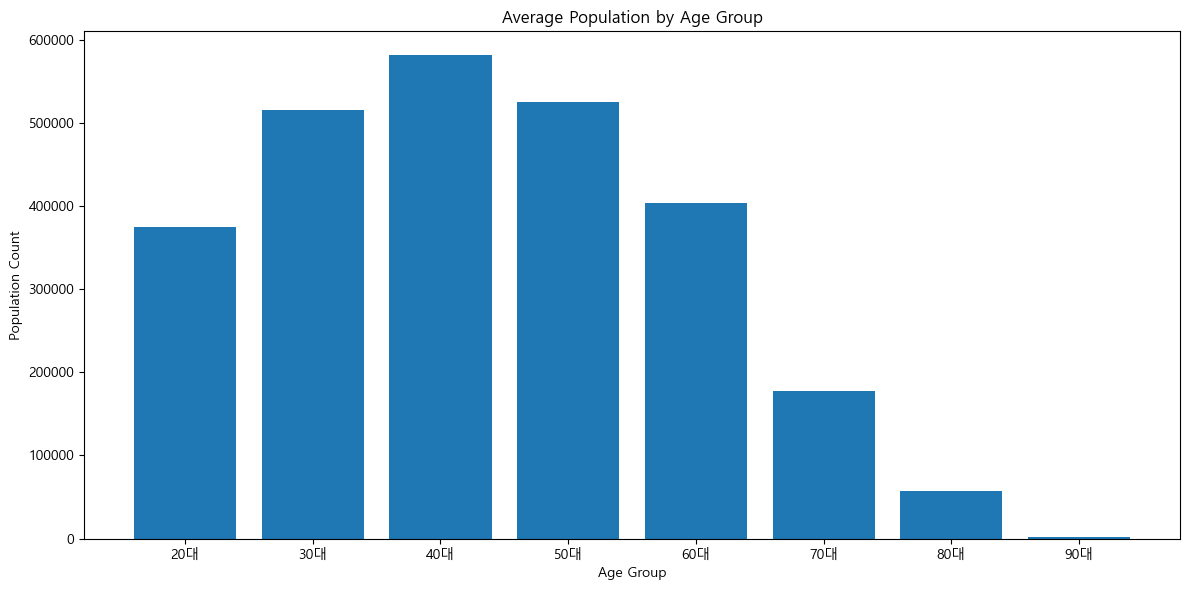

In [5]:
# 필요한 열만 선택
age_totals = grid_respop[['year', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100대']]

# 데이터프레임을 긴 형식으로 변환
age_totals_melted = age_totals.melt(id_vars='year', var_name='Age Group', value_name='Count')

# 연도별 연령대 분포 계산
age_totals_yearly = age_totals_melted[['Age Group', 'Count']].groupby(['Age Group']).sum().reset_index()
# 100대 연령대 제거
age_totals_yearly = age_totals_yearly[age_totals_yearly['Age Group'] != '100대']

# 나이 그룹과 카운트 추출
age_groups = age_totals_yearly['Age Group']
counts = age_totals_yearly['Count']

# 그래프 사이즈 설정
plt.figure(figsize=(12, 6))

# 기본 색상으로 바 차트 생성
plt.bar(age_groups, counts)

# 레이블 및 타이틀 설정
plt.xlabel('Age Group')
plt.ylabel('Population Count')
plt.title('Average Population by Age Group')
plt.xticks(rotation=0)  # 레이블 수평 유지

# 시각화 출력
plt.tight_layout()
plt.show()

In [6]:
# 거주인구 - 격자에 mapping작업
grid_respop = grid_respop[['gbn', 'gid', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100대', '인구']]

# 생성된 map_dic에 filtered_respop의 gid를 매핑하여 'geometry' column 생성
geometry_lst = []
for _, row in tqdm(grid_respop.iterrows()):
    geometry_lst.append(grid_analyze_dict[row['gid']])
grid_respop['geometry'] = geometry_lst
grid_respop = gpd.GeoDataFrame(grid_respop, geometry='geometry')

# 중심점 계산
grid_respop['centroid'] = grid_respop['geometry'].centroid

# 중심점의 경도 (x), 위도 (y)를 각각 lon, lat 열로 추가
grid_respop['lon'] = grid_respop['centroid'].x
grid_respop['lat'] = grid_respop['centroid'].y

# centroid 열이 불필요하면 제거
grid_respop = grid_respop.drop(columns='centroid')

111637it [00:06, 17706.14it/s]


In [7]:
grid_respop

,gbn,gid,20대,30대,40대,50대,60대,70대,80대,90대,100대,인구,geometry,lon,lat
0,인천광역시 서구,다사139554,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.52470 37.59398, 126.52469 37.594...",126.525258,37.594436
1,인천광역시 서구,다사268544,14,19,31,17,0,0,0,0,0,81,"POLYGON ((126.67091 37.58609, 126.67090 37.586...",126.671469,37.586540
2,인천광역시 서구,다사268522,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.67113 37.56626, 126.67112 37.567...",126.671688,37.566712
3,인천광역시 서구,다사268523,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.67112 37.56716, 126.67111 37.568...",126.671678,37.567614
4,인천광역시 서구,다사268524,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.67111 37.56806, 126.67110 37.568...",126.671668,37.568515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111632,경기도 화성시,다사341163,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.75698 37.24324, 126.75697 37.244...",126.757543,37.243695
111633,경기도 화성시,다사341164,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.75697 37.24414, 126.75697 37.245...",126.757534,37.244596
111634,경기도 화성시,다사341165,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.75697 37.24504, 126.75696 37.245...",126.757525,37.245498
111635,경기도 화성시,다사341166,0,0,0,0,0,0,0,0,0,0,"POLYGON ((126.75696 37.24594, 126.75695 37.246...",126.757516,37.246399


In [ ]:
# 맵 객체 생성 및 데이터 로드
grid_map = KeplerGl(height=1000, width=1500)
grid_map.add_data(data=grid_respop, name="격자거주인구 데이터")

# 맵 출력 및 상세설정
grid_map

In [ ]:
# 맵 저장
# grid_map.save_to_html(file_name="visualization/화성시 현황/화성시 격자거주인구 map.html")

Map saved to visualization/화성시 현황/화성시 격자거주인구 map.html!


#### 유동인구

In [8]:
# 유동인구 df 로드
floating_population_df = pd.read_csv('SBJ_2504_001/05._성연령별_유동인구.csv')
floating_population_df['STD_YM'] = floating_population_df['STD_YM'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['gbn', 'year']
for i in range(2, 14):
    floating_population_df[floating_population_df.columns[i]] = floating_population_df[floating_population_df.columns[i]].astype(float)
    new_col = f'{floating_population_df.columns[i][2:4]}대_남' if floating_population_df.columns[i][0] == 'm' else f'{floating_population_df.columns[i][2:4]}대_여'
    columns.append(new_col)
floating_population_df.columns = columns + floating_population_df.columns[14:16].tolist()
floating_population_df['총합'] = floating_population_df.iloc[:, 2:-2].sum(axis=1)
floating_population_df['year'] = floating_population_df['year'].apply(lambda x : x[2:])
floating_population_df = geo_transform(floating_population_df)

col_lst = ['gbn', 'year'] + list(floating_population_df.columns[-2:]) + ['총합']
floating_population_df = floating_population_df[col_lst]

floating_pop = gpd.sjoin(floating_population_df, grid_analyze, how='inner', op='within')

floating_pop['year'] = "20" + floating_pop['year'].astype(str).str[:2]
floating_pop['year'] = floating_pop['year'].astype(int)

# 필요한 열만 남기기
floating_pop = floating_pop.rename(columns={'properties.gid': 'gid'})
floating_pop = floating_pop[['gbn_left', 'gid', '총합', 'geometry']]
floating_pop = floating_pop.rename(columns={'gbn_left': 'gbn'})
floating_pop = pd.concat([floating_pop.iloc[:,:3], floating_pop.iloc[:,-1:]], axis=1)
floating_pop  = gpd.GeoDataFrame(floating_pop , geometry='geometry')

# 그룹화 및 집계 수행
floating_pop  = floating_pop.dissolve(
    by=['gbn', 'gid'],
    aggfunc={'총합': 'sum'}
).reset_index()

floating_pop ['geometry'] = floating_pop ['gid'].map(grid_analyze_dict)
floating_pop  = gpd.GeoDataFrame(floating_pop , geometry='geometry')

100%|██████████| 3734223/3734223 [01:41<00:00, 36806.46it/s]
c:\Users\hjk\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\hjk\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\hjk\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\hjk\AppData\Local\Temp\i

In [9]:
floating_pop

,gbn,gid,geometry,총합
0,경기도 성남시,다사581305,"POLYGON ((127.02677 37.37262, 127.02676 37.373...",3.24
1,경기도 성남시,다사582304,"POLYGON ((127.02790 37.37173, 127.02790 37.372...",0.93
2,경기도 성남시,다사582305,"POLYGON ((127.02790 37.37263, 127.02789 37.373...",5.55
3,경기도 성남시,다사582306,"POLYGON ((127.02789 37.37353, 127.02789 37.374...",2.45
4,경기도 성남시,다사582307,"POLYGON ((127.02789 37.37443, 127.02788 37.375...",1.42
...,...,...,...,...
96732,인천광역시 서구,다사314551,"POLYGON ((126.72294 37.59275, 126.72293 37.593...",540.59
96733,인천광역시 서구,다사314552,"POLYGON ((126.72293 37.59365, 126.72292 37.594...",2531.00
96734,인천광역시 서구,다사315550,"POLYGON ((126.72408 37.59186, 126.72407 37.592...",616.61
96735,인천광역시 서구,다사315551,"POLYGON ((126.72407 37.59276, 126.72406 37.593...",377.85


In [ ]:
# 맵 객체 생성 및 데이터 로드
floatingpop_map = KeplerGl(height=1000, width=1500)
floatingpop_map.add_data(data=floating_pop, name="유동인구 데이터")

floatingpop_map

#### 상권 접근성(행정구역별로 구분해서 도출)

In [10]:
# 각 도시 면적 계산 후 면적 기준으로 top_n, min_distance_km 설정
# 성남시: 수정구, 중원구, 분당구 병합
sungnam_gdfs = [
    gpd.read_file("SBJ_2504_001/bnd_dong_31021_2023_4Q/bnd_dong_31021_2023_4Q.shp"),
    gpd.read_file("SBJ_2504_001/bnd_dong_31022_2023_4Q/bnd_dong_31022_2023_4Q.shp"),
    gpd.read_file("SBJ_2504_001/bnd_dong_31023_2023_4Q/bnd_dong_31023_2023_4Q.shp")
]
sungnam_gdf = pd.concat(sungnam_gdfs).to_crs(epsg=5179)  # meters-based 좌표계로 변환
area_sungnam = sungnam_gdf.geometry.area.sum() / 1e6  # km²로 변환

# 하남시
hanam_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_31180_2023_4Q/bnd_dong_31180_2023_4Q.shp").to_crs(epsg=5179)
area_hanam = hanam_gdf.geometry.area.sum() / 1e6

# 화성시
hwasung_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_31240_2023_4Q/bnd_dong_31240_2023_4Q.shp").to_crs(epsg=5179)
area_hwasung = hwasung_gdf.geometry.area.sum() / 1e6

# 송파구
songpa_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_11240_2023_4Q/bnd_dong_11240_2023_4Q.shp").to_crs(epsg=5179)
area_songpa = songpa_gdf.geometry.area.sum() / 1e6

# 인천 서구
incheon_seo_gdf = gpd.read_file("SBJ_2504_001/bnd_dong_23080_2023_4Q/bnd_dong_23080_2023_4Q.shp").to_crs(epsg=5179)
area_incheon_seo = incheon_seo_gdf.geometry.area.sum() / 1e6

In [11]:
# 도시별 면적 딕셔너리
area_dict = {
    '경기도 성남시': area_sungnam,
    '경기도 하남시': area_hanam,
    '경기도 화성시': area_hwasung,
    '서울특별시 송파구': area_songpa,
    '인천광역시 서구': area_incheon_seo,
}

def get_kde_params(area_km2, base_area=100, base_top_n=10, base_distance=2, max_top_n=10):
    """
    도시 면적을 기준으로 KDE 파라미터(top_n, min_distance_km)를 설정한다.
    - top_n은 log1p 비율 기반으로 증가
    - min_distance_km은 sqrt 기반 증가
    - 둘 다 상한선 설정 가능
    """
    ratio = area_km2 / base_area

    # log 기반 완화 증가, 최소 5개 이상, 최대 max_top_n 제한
    top_n = min(max_top_n, max(5, int(base_top_n * np.log1p(ratio))))

    # 거리 기준은 면적의 sqrt 비례 증가
    min_dist = round(base_distance * np.sqrt(ratio), 1)

    return top_n, min_dist

# 도시별 매개변수 계산
param_dict = {}
for city, area in area_dict.items():
    top_n, min_dist = get_kde_params(area)
    param_dict[city] = {'top_n': top_n, 'min_distance_km': min_dist}

# 확인
from pprint import pprint
pprint(param_dict)


{'경기도 성남시': {'min_distance_km': 2.4, 'top_n': 8},
 '경기도 하남시': {'min_distance_km': 1.9, 'top_n': 6},
 '경기도 화성시': {'min_distance_km': 5.6, 'top_n': 10},
 '서울특별시 송파구': {'min_distance_km': 1.2, 'top_n': 5},
 '인천광역시 서구': {'min_distance_km': 2.3, 'top_n': 8}}


In [13]:
from scipy.stats import gaussian_kde
from geopy.distance import geodesic

business_area_data = pd.read_csv('SBJ_2504_001/02. 상권정보.csv')
business_area_data = geo_transform(business_area_data)

# 나눌 기준이 되는 지역 리스트로 지역별 데이터프레임을 담을 딕셔너리 생성
region_list = ['경기도 성남시', '경기도 하남시', '경기도 화성시', '서울특별시 송파구', '인천광역시 서구']
region_dfs = {}

# 각 지역에 대해 필터링하여 별도 DataFrame 생성
for region in region_list:
    region_dfs[region] = business_area_data[business_area_data['gbn'] == region]

100%|██████████| 108963/108963 [00:02<00:00, 43101.98it/s]
c:\Users\hjk\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\hjk\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6




▶ 경기도 성남시 - top_n: 8, min_distance_km: 2.4


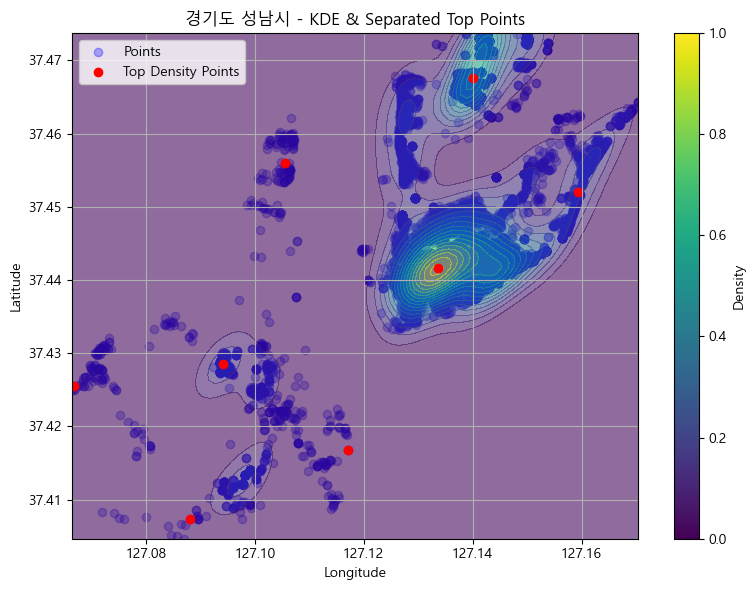


▶ 경기도 하남시 - top_n: 6, min_distance_km: 1.9


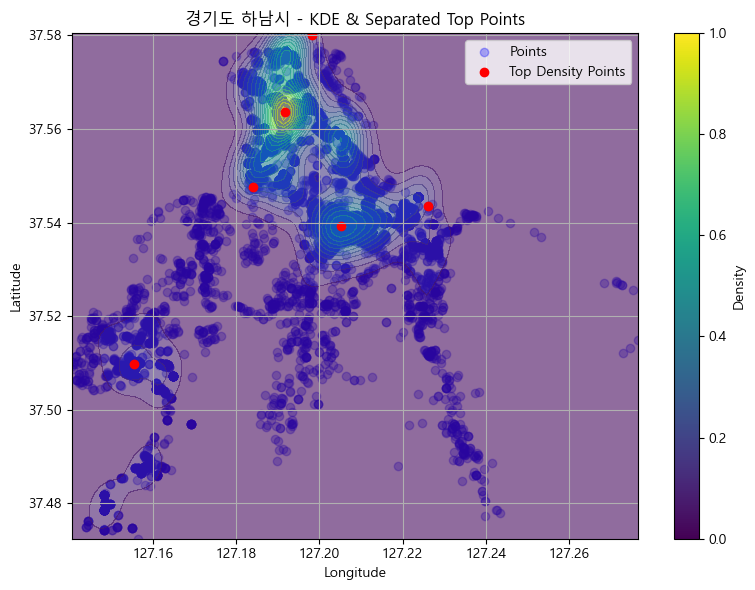


▶ 경기도 화성시 - top_n: 10, min_distance_km: 5.6


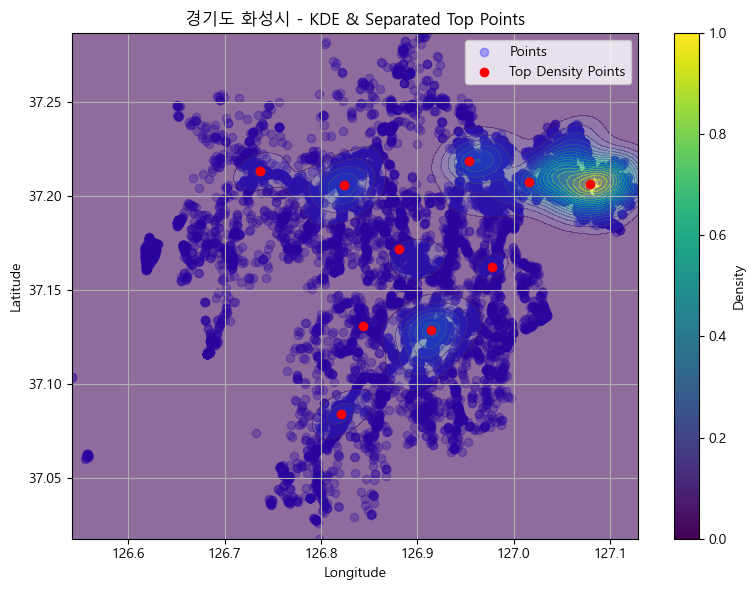


▶ 서울특별시 송파구 - top_n: 5, min_distance_km: 1.2


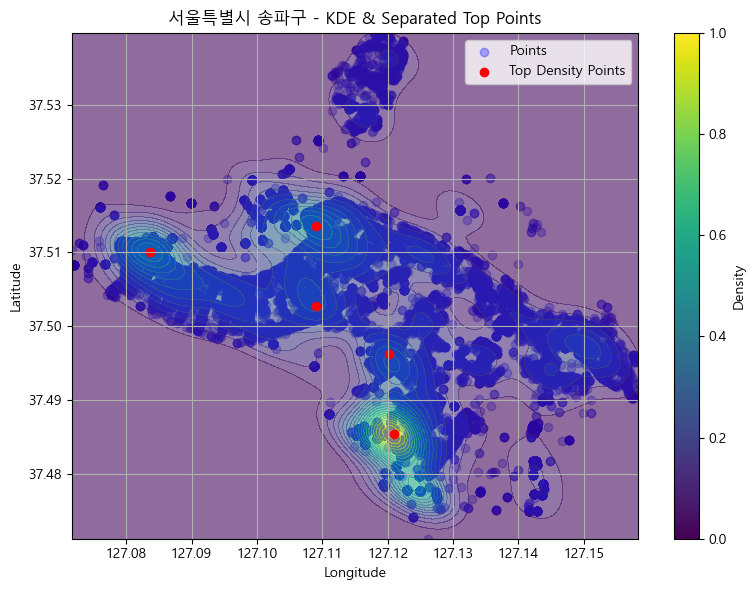


▶ 인천광역시 서구 - top_n: 8, min_distance_km: 2.3


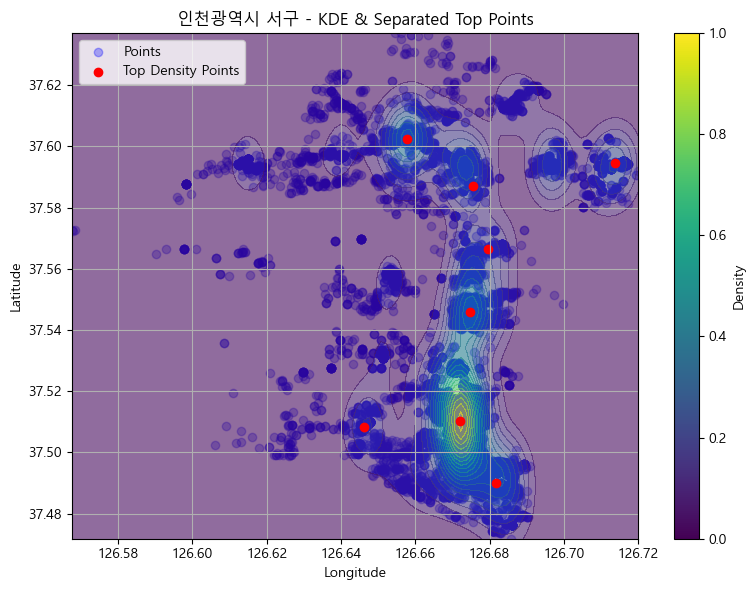

In [14]:
def find_separated_density_points(data, lon_col='lon', lat_col='lat', top_n=10, min_distance_km=1):
    coords = data[[lon_col, lat_col]].values.T  # (2, N)

    kde = gaussian_kde(coords)
    density = kde(coords)
    data = data.copy()
    data['density'] = density
    data = data.sort_values('density', ascending=False).reset_index(drop=True)

    selected_points = []
    remaining_points = data.copy()

    MAX_POINTS = 10

    while len(selected_points) < min(top_n, MAX_POINTS) and not remaining_points.empty:
        top_point = remaining_points.iloc[0]
        selected_points.append(top_point)

        remaining_points['distance'] = remaining_points.apply(
            lambda row: geodesic(
                (top_point[lat_col], top_point[lon_col]),
                (row[lat_col], row[lon_col])
            ).km,
            axis=1
        )

        remaining_points = remaining_points[remaining_points['distance'] > min_distance_km].reset_index(drop=True)

    selected_points_df = pd.DataFrame(selected_points)
    return selected_points_df, kde


def plot_separated_density_map(data, kde, top_points, region_name, lon_col='lon', lat_col='lat', resolution=100):
    x = np.linspace(data[lon_col].min(), data[lon_col].max(), resolution)
    y = np.linspace(data[lat_col].min(), data[lat_col].max(), resolution)
    X, Y = np.meshgrid(x, y)
    grid_coords = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(grid_coords).reshape(X.shape)

    plt.figure(figsize=(8, 6))
    plt.scatter(data[lon_col], data[lat_col], c='blue', alpha=0.3, label='Points')
    plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.6)
    plt.scatter(top_points[lon_col], top_points[lat_col], color='red', label='Top Density Points')
    plt.colorbar(label='Density')
    plt.title(f'{region_name} - KDE & Separated Top Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_kde_for_all_regions(region_dfs, param_dict):
    results = {}
    for region_name, df in region_dfs.items():
        if region_name not in param_dict:
            print(f"[{region_name}] 파라미터 없음, 스킵합니다.")
            continue

        params = param_dict[region_name]
        top_n = params['top_n']
        min_distance = params['min_distance_km']

        print(f"\n▶ {region_name} - top_n: {top_n}, min_distance_km: {min_distance}")
        top_points, kde = find_separated_density_points(df, top_n=top_n, min_distance_km=min_distance)
        plot_separated_density_map(df, kde, top_points, region_name)
        results[region_name] = top_points


    return results  # 각 도시별로 top_points 저장된 딕셔너리 반환

# param_dict, region_dfs를 바탕으로 실행
all_top_points = run_kde_for_all_regions(region_dfs, param_dict)

In [15]:
all_top_points['경기도 화성시']

,gbn,com_lc_cd,com_lc_nm,com_mc_cd,com_mc_nm,com_sc_cd,com_sc_nm,ksic_cd,ksic_nm,adb_emd_cd,adb_emd_nm,road_address,lon,lat,geometry,density,distance
0,경기도 화성시,I2,음식,I212,비알코올,I21201,카페,I56221,커피 전문점,41590585,동탄1동,경기도 화성시 노작로 226-26,127.078916,37.206654,POINT (127.0789157 37.20665445),185.215848,NaN
0,경기도 화성시,M1,과학·기술,M105,광고,M10503,광고 매체 판매업,M71392,광고 매체 판매업,41590570,화산동,경기도 화성시 화산남로 57,127.015681,37.207606,POINT (127.0156805 37.20760565),67.687279,5.614359
0,경기도 화성시,G2,소매,G208,가전·통신 소매,G20801,컴퓨터/소프트웨어 소매업,G47311,"컴퓨터 및 주변장치, 소프트웨어 소매업",41590259,향남읍,경기도 화성시 향남읍 행정서로1길 47-11,126.914087,37.128890,POINT (126.9140866 37.12889024),65.438405,12.559134
0,경기도 화성시,I2,음식,I201,한식,I20107,돼지고기 구이/찜,I56113,한식 육류 요리 전문점,41590253,봉담읍,경기도 화성시 봉담읍 동화길 42,126.954194,37.218928,POINT (126.9541935 37.21892812),58.346387,10.608319
0,경기도 화성시,I2,음식,I201,한식,I20112,해산물 구이/찜,I56111,한식 일반 음식점업,41590262,남양읍,경기도 화성시 남양읍 역골로 78,126.823797,37.205874,POINT (126.8237966 37.20587375),49.832245,11.664802
0,경기도 화성시,P1,교육,P106,기타 교육,P10601,태권도/무술학원,P85611,태권도 및 무술 교육기관,41590256,우정읍,경기도 화성시 우정읍 31만세로 69-5,126.820711,37.084025,POINT (126.8207107 37.08402456),24.622450,13.525646
0,경기도 화성시,I2,음식,I201,한식,I20101,백반/한정식,I56111,한식 일반 음식점업,41590340,송산면,경기도 화성시 송산면 사강로 187,126.736660,37.213266,POINT (126.7366604 37.21326633),21.155387,16.170483
0,경기도 화성시,G2,소매,G210,철물·건설자재 소매,G21001,철물/공구 소매업,G47512,공구 소매업,41590410,정남면,경기도 화성시 정남면 신새말길 27-1,126.978011,37.162250,POINT (126.9780108 37.16224975),12.419157,22.165383
0,경기도 화성시,M1,과학·기술,M112,전문 디자인,M11202,제품 디자인업,M73202,제품 디자인업,41590360,팔탄면,경기도 화성시 팔탄면 밤뒤길 65,126.881187,37.171936,POINT (126.8811874 37.17193601),11.736330,8.666446
0,경기도 화성시,S2,수리·개인,S207,이용·미용,S20701,미용실,S96112,두발 미용업,41590360,팔탄면,경기도 화성시 팔탄면 버들로 1239,126.844145,37.131004,POINT (126.8441449 37.13100427),6.989451,5.609269


#### 도시잠재력지표

In [21]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/04._도시잠재력지표.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
city_pot = pd.json_normalize(geojson_data['features'])
city_pot['geometry'] = city_pot['geometry.coordinates'].apply(lambda x : make_point(x))
city_pot = gpd.GeoDataFrame(city_pot, geometry='geometry')

# 제거할 열 리스트
drop_cols = ['type', 'properties.fid', 'properties.sido_cd', 'properties.sgg_cd', 'geometry.type', 'geometry.coordinates']
city_pot = city_pot.drop(columns=drop_cols)

# 'properties.' 접두사 제거
city_pot.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in city_pot.columns
]

rename_dict = {
    'ps_01': '기개발지 접근',
    'ps_02': '시군구청 접근',
    'ps_03': '공공편의시설 접근',
    'ps_04': '지장물 현황',
    'ps_05': '고속도로IC 접근',
    'ps_06': '간선도로 접근',
    'ps_07': '철도역사 접근',
    'ps_08': '여객터미널 접근',
    'ps_09': '피복분류',
    'ps_10': '용도지역',
    'ps_11': '인허가',
    'ps_12': '지역내 총생산',
    'ps_13': '지가경쟁력',
    'ps_14': '지가수준',
    'ps_15': '지가변동률',
    'ps_16': '인구증감률',
    'ps_17': '인구밀도',
    'ps_18': '경제활동인구수',
    'ps_19': '세대증감률',
    'ps_20': '사업체수',
    'ps_21': '주택보급률',
    'ps_22': '등록공장현황',
    'ps_23': '국공유지',
    'ps_24': '표고',
    'ps_25': '경사도',
    'ps_26': '국토환경성평가',
}

# 열 이름 변경
city_pot.rename(columns=rename_dict, inplace=True)

In [22]:
city_pot

,gbn,기개발지 접근,시군구청 접근,공공편의시설 접근,지장물 현황,고속도로IC 접근,간선도로 접근,철도역사 접근,여객터미널 접근,피복분류,용도지역,인허가,지역내 총생산,지가경쟁력,지가수준,지가변동률,인구증감률,인구밀도,경제활동인구수,세대증감률,사업체수,주택보급률,등록공장현황,국공유지,표고,경사도,국토환경성평가,geometry
0,경기도 하남시,0.079537,0.827639,138,25.0000,0.967270,1.047060,1.440420,9.095250,3,5,0,8087877,0.111559,82.6087,88.8889,2.32,3539.53,231595,4.056,14159,76.5,0.004,0.00,-97.4320,0.994051,1,POINT (127.20184 37.57516)
1,경기도 하남시,0.040634,0.742950,126,29.1667,1.035920,1.112560,1.474870,9.213120,3,5,0,8087877,0.131865,82.6087,88.8889,2.32,3539.53,231595,4.056,14159,76.5,0.004,0.00,-98.4801,0.982242,1,POINT (127.20183 37.57408)
2,경기도 하남시,0.024822,0.669152,110,75.0000,1.113100,1.178870,1.381490,9.331050,1,5,0,8087877,0.337891,82.6087,88.8889,2.32,3539.53,231595,4.056,14159,76.5,0.004,0.00,-97.5667,1.257300,1,POINT (127.20183 37.57300)
3,경기도 하남시,0.003153,0.610209,105,79.1667,1.197350,1.250720,1.287120,9.449030,1,1,0,8087877,0.438385,82.6087,88.8889,2.32,3539.53,231595,4.056,14159,76.5,0.004,0.25,-96.2208,0.737590,1,POINT (127.20183 37.57192)
4,경기도 하남시,0.000000,0.570741,101,41.6667,1.287290,1.327730,1.197350,9.567060,1,1,0,8087877,0.546649,82.6087,88.8889,2.32,3539.53,231595,4.056,14159,76.5,0.004,0.00,-95.7169,0.966153,1,POINT (127.20182 37.57084)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69912,서울특별시 송파구,0.437846,1.195060,464,0.0000,0.610998,0.259557,0.937680,0.975852,1,5,5,31834324,0.078156,0.0000,0.0000,-0.54,19201.60,465903,0.573,30077,98.1,0.003,1.00,-51.9819,0.102867,1,POINT (127.10533 37.53636)
69913,서울특별시 송파구,0.497763,1.218490,452,0.0000,0.502385,0.183915,0.937007,0.953705,1,5,5,31834324,0.078156,0.0000,0.0000,-0.54,19201.60,465903,0.573,30077,98.1,0.003,1.00,-52.0172,0.031376,1,POINT (127.10533 37.53528)
69914,서울특별시 송파구,0.497647,1.253030,450,0.0000,0.399395,0.108273,0.943655,0.946295,1,5,5,31834324,0.077910,0.0000,0.0000,-0.54,19201.60,465903,0.573,30077,98.1,0.003,1.00,-52.0436,0.027775,1,POINT (127.10533 37.53420)
69915,서울특별시 송파구,0.478329,1.297780,454,0.0000,0.307010,0.037368,0.965292,0.954033,1,5,5,31834324,0.077663,0.0000,0.0000,-0.54,19201.60,465903,0.573,30077,98.1,0.003,1.00,-52.0466,0.040605,1,POINT (127.10533 37.53312)


In [ ]:
# 맵 객체 생성 및 데이터 로드
city_pot_map = KeplerGl(height=1000, width=1500)
city_pot_map.add_data(data=city_pot, name="도시잠재력 데이터")

# 맵 출력 및 상세설정
city_pot_map

#### 토지이용계획도

In [26]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/11. 토지이용계획도.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
areaplan = pd.json_normalize(geojson_data['features'])
areaplan['geometry'] = areaplan['geometry.coordinates'].apply(lambda x : make_pol(x))
areaplan = gpd.GeoDataFrame(areaplan, geometry='geometry')
areaplan_target = areaplan[areaplan['properties.zoneName']=='광명시흥 공공주택지구'] # 광명시흥지구만 추출
areaplan_target = areaplan_target[['properties.blockName', 'properties.blockType', 'geometry']]
areaplan_target.columns = ['blockName', 'blockType', 'geometry']

# 엑셀 파일 불러오기
plan_info = pd.read_excel("SBJ_2504_001/26. (참고자료) 토지이용_구역별계획.xlsx")

groupings = {
    "1": ["D2-1", "D2-2"],  # 건설호수 96, 인구 239
    "2": ["D1-1", "D1-2", "D1-3", "D1-4", "D1-5", "D1-6", "D1-7", "D1-8", "D1-9", "D1-10", "D1-11", "D1-12", "D1-13", "D1-14",
          "D2-3", "D2-4", "D2-5", "D2-6", "D2-7", "D2-8", "D2-9", "D2-10", "D2-11"],  # 971, 2428
    "3": ["BD1-1", "BD1-2", "BD2-1", "BD2-2"],  # 건설호수 161, 인구 403
}
group_values = {
    "1": {"건설호수": 96, "인구": 239},
    "2": {"건설호수": 971, "인구": 2428},
    "3": {"건설호수": 161, "인구": 403},
}

# 엑셀 데이터에 건설호수/인구 배분
plan_info["건설호수_추정"] = None
plan_info["인구_추정"] = None

for group, zones in groupings.items():
    if group not in group_values:
        continue  # 값 없는 그룹은 생략

    subset = plan_info[plan_info["구역"].isin(zones)].copy()
    total_area = subset["면적"].sum()
    if total_area == 0:
        continue

    # 비율 계산
    area_ratio = subset["면적"] / total_area
    plan_info.loc[plan_info["구역"].isin(zones), "건설호수_추정"] = (area_ratio * group_values[group]["건설호수"]).round().astype("Int64")
    plan_info.loc[plan_info["구역"].isin(zones), "인구_추정"] = (area_ratio * group_values[group]["인구"]).round().astype("Int64")

# 기존 코드 이후에 이 블록만 추가
for group, zones in groupings.items():
    if group not in group_values:
        continue  # 값이 없는 그룹은 생략

    # 건설호수_추정 → 건설호수, 인구_추정 → 인구
    plan_info.loc[plan_info["구역"].isin(zones), "건설호수"] = plan_info.loc[plan_info["구역"].isin(zones), "건설호수_추정"]
    plan_info.loc[plan_info["구역"].isin(zones), "인구"] = plan_info.loc[plan_info["구역"].isin(zones), "인구_추정"]

# 필요한 열만 선택
columns_to_merge = ['구역', '면적', '건설호수', '인구', '주택유형']
plan_info = plan_info[columns_to_merge]

# 병합 수행 ('blockName' <-> '구역' 기준, left join으로 기존 areaplan_target에 추가 열 붙이기)
areaplan_target = areaplan_target.merge(plan_info, how='left', left_on='blockName', right_on='구역')
areaplan_target['건설호수'] = areaplan_target['건설호수'].astype('Int64')
areaplan_target['인구'] = areaplan_target['인구'].astype('Int64')

# 불필요한 '구역' 열 제거 (원하는 경우)
areaplan_target.drop(columns='구역', inplace=True)

In [27]:
areaplan_target['blockType'].unique()

array(['단독주택', '공원', '공동주택', '녹지', '철도시설용지', '일반상업', '하천', '근린생활시설용지',
       '보행자전용도로', '공공청사', '교육시설', '수도공급시설', '하수종말처리시설', '주차장', '자족기능확보시설',
       '근린상업', '도로', '주상복합', '자동차정류장', '문화시설', '공공공지', '종교시설', '전기공급설비',
       '복합용지', '주유소용지', '교통광장', '폐기물처리시설', '유보지', '업무시설', '열공급설비'],
      dtype=object)

In [ ]:
# 맵 객체 생성 및 데이터 로드
areaplan_map = KeplerGl(height=1000, width=1500)
areaplan_map.add_data(data=areaplan_target, name="토지이용계획 데이터")

# 맵 출력 및 상세설정
areaplan_map

#### 탄소배출량

In [28]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/12._탄소배출량_전기부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_elec = pd.json_normalize(geojson_data['features'])
emission_elec['geometry'] = emission_elec['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_elec = emission_elec.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_elec.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_elec.columns
]

# 우선 정렬: grid_cd 기준 + e_tot 큰 값 우선
emission_elec = emission_elec.sort_values(['grid_cd', 'e_tot'], ascending=[True, False])

# 숫자 컬럼 목록 정의 (열 이름 자동 추출 가능)
value_cols = [col for col in emission_elec.columns if col.startswith('e_')]

# groupby하여 병합
emission_elec = (
    emission_elec
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # e_tot 큰 값 기준으로 gbn 선택
        'geometry': 'first',  # 동일하므로 아무거나
        **{col: 'sum' for col in value_cols}  # 탄소배출량은 전부 합산
    })
)
emission_elec = gpd.GeoDataFrame(emission_elec, geometry='geometry')

In [29]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/13._탄소배출량_가스부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_gas = pd.json_normalize(geojson_data['features'])
emission_gas['geometry'] = emission_gas['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_gas = emission_gas.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_gas.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_gas.columns
]

# 우선 정렬: grid_cd 기준 + g_tot 큰 값 우선
emission_gas = emission_gas.sort_values(['grid_cd', 'g_tot'], ascending=[True, False])

# 숫자 컬럼 목록 정의 (열 이름 자동 추출 가능)
value_cols = [col for col in emission_gas.columns if col.startswith('g_')]

# groupby하여 병합
emission_gas = (
    emission_gas
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # g_tot 큰 값 기준으로 gbn 선택
        'geometry': 'first',  # 동일하므로 아무거나
        **{col: 'sum' for col in value_cols}  # 탄소배출량은 전부 합산
    })
)
emission_gas = gpd.GeoDataFrame(emission_gas, geometry='geometry')

In [30]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/14._탄소배출량_난방부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_heat = pd.json_normalize(geojson_data['features'])
emission_heat['geometry'] = emission_heat['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_heat = emission_heat.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_heat.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_heat.columns
]

# 우선 정렬: grid_cd 기준 + h_tot 큰 값 우선
emission_heat = emission_heat.sort_values(['grid_cd', 'h_tot'], ascending=[True, False])

# 숫자 컬럼 목록 정의 (열 이름 자동 추출 가능)
value_cols = [col for col in emission_heat.columns if col.startswith('h_')]

# groupby하여 병합
emission_heat = (
    emission_heat
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # h_tot 큰 값 기준으로 gbn 선택
        'geometry': 'first',  # 동일하므로 아무거나
        **{col: 'sum' for col in value_cols}  # 탄소배출량은 전부 합산
    })
)
emission_heat = gpd.GeoDataFrame(emission_heat, geometry='geometry')

In [31]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/15._탄소배출량_수송부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
emission_transport = pd.json_normalize(geojson_data['features'])
emission_transport['geometry'] = emission_transport['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
emission_transport = emission_transport.drop(columns=drop_cols)

# 'properties.' 접두사 제거
emission_transport.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in emission_transport.columns
]

# 우선 정렬: grid_cd 기준 + road_tco2 큰 값이 먼저 오도록
emission_transport = emission_transport.sort_values(['grid_cd', 'road_tco2'], ascending=[True, False])

# groupby하여 통합
emission_transport = (
    emission_transport
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # road_tco2가 큰 값의 gbn을 가져오기 위해 정렬한 상태에서 first
        'road_tco2': 'sum',
        'geometry': 'first'  # 어차피 동일
    })
)

emission_transport = gpd.GeoDataFrame(emission_transport, geometry='geometry')

In [ ]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=emission_elec[emission_elec['e_tot']<100000], name="확인")

# 맵 출력 및 상세설정
map

#### 임상도

In [32]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/03. 임상도.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
forest = pd.json_normalize(geojson_data['features'])
forest['geometry'] = forest['geometry.coordinates'].apply(lambda x : make_pol(x))
forest = forest[forest['properties.FRTP_NM']!="무립목지/비산림"] # 비산림 제거
forest = gpd.GeoDataFrame(forest, geometry='geometry')

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
forest = forest.drop(columns=drop_cols)

# 'properties.' 접두사 제거
forest.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in forest.columns
]

forest = forest[['gbn', 'geometry']]

In [51]:
forest

,gbn,geometry
2,경기도 성남시,"POLYGON ((127.07640 37.39561, 127.07637 37.395..."
3,경기도 성남시,"POLYGON ((127.07856 37.39649, 127.07840 37.396..."
4,경기도 성남시,"POLYGON ((127.08197 37.39912, 127.08197 37.399..."
5,경기도 성남시,"POLYGON ((127.04610 37.41679, 127.04612 37.416..."
6,경기도 성남시,"POLYGON ((127.06076 37.39981, 127.06038 37.399..."
...,...,...
22815,인천광역시 서구,"POLYGON ((126.65967 37.61990, 126.65967 37.619..."
22816,인천광역시 서구,"POLYGON ((126.65362 37.62249, 126.65364 37.622..."
22817,인천광역시 서구,"POLYGON ((126.64491 37.62849, 126.64490 37.628..."
22818,인천광역시 서구,"POLYGON ((126.65780 37.63161, 126.65780 37.631..."


In [35]:
# 좌표계 확인 및 통일 (면적 계산을 위해 meters 단위 투영 좌표계로 변환)
forest = forest.set_crs(epsg=4326)
grid_analyze = grid_analyze.set_crs(epsg=4326)
crs_projected = 'EPSG:5181'  # 중부원점(미터 단위)

forest_proj = forest.to_crs(crs_projected)
grid_proj = grid_analyze.to_crs(crs_projected)

# 공간 교차 분석: 격자와 겹치는 녹지 영역 구하기
intersection = gpd.overlay(grid_proj, forest_proj, how='intersection')

# 교차 면적 계산
intersection['green_area_m2'] = intersection['geometry'].area

# 격자 전체 면적 계산
grid_proj['grid_area_m2'] = grid_proj['geometry'].area

# 교차된 녹지 면적을 격자별로 합산
green_by_grid = (
    intersection
    .groupby('gid')[['green_area_m2']]
    .sum()
    .reset_index()
)

# 격자 전체 면적과 병합
grid_result = grid_proj.merge(green_by_grid, on='gid', how='left')

# 비율 계산 (녹지 없는 경우 NaN → 0 처리)
grid_result['green_area_m2'] = grid_result['green_area_m2'].fillna(0)
grid_result['green_ratio'] = (grid_result['green_area_m2'] / grid_result['grid_area_m2'] * 100).round(2)

grid_result = grid_result[['gbn', 'gid', 'geometry', 'green_area_m2', 'green_ratio']]

In [36]:
grid_result

,gbn,gid,geometry,green_area_m2,green_ratio
0,경기도 하남시,다사710491,"POLYGON ((215177.115 449042.850, 215176.583 44...",0.000000,0.00
1,경기도 하남시,다사732511,"POLYGON ((217367.310 451055.315, 217366.777 45...",0.000000,0.00
2,경기도 하남시,다사703464,"POLYGON ((214491.209 446338.107, 214490.678 44...",0.000000,0.00
3,경기도 하남시,다사734504,"POLYGON ((217571.111 450356.112, 217570.579 45...",2.623388,0.03
4,경기도 하남시,다사731458,"POLYGON ((217295.461 445752.764, 217294.929 44...",0.000000,0.00
...,...,...,...,...,...
111454,경기도 성남시,다사605350,"POLYGON ((204748.096 434881.820, 204747.566 43...",10007.626628,100.00
111455,경기도 성남시,다사589317,"POLYGON ((203165.008 431572.128, 203164.478 43...",0.000000,0.00
111456,경기도 성남시,다사585308,"POLYGON ((202769.631 430669.679, 202769.101 43...",0.000000,0.00
111457,경기도 성남시,다사671290,"POLYGON ((211382.348 428914.580, 211381.818 42...",0.000000,0.00


In [37]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=forest, name="임상도")
map.add_data(data=grid_result, name="녹지비율")

# 맵 출력 및 상세설정
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'임상도': {'index': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2…

#### 탄소흡수량

In [39]:
# GeoJSON 파일 불러오기
with open('SBJ_2504_001/16._탄소흡수량_산림부문.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
absorption = pd.json_normalize(geojson_data['features'])
absorption['geometry'] = absorption['geometry.coordinates'].apply(lambda x : make_pol(x))

# 제거할 열 리스트
drop_cols = ['type', 'geometry.type', 'geometry.coordinates']
absorption = absorption.drop(columns=drop_cols)

# 'properties.' 접두사 제거
absorption.columns = [
    col.replace('properties.', '') if col.startswith('properties.') else col
    for col in absorption.columns
]

# 우선 정렬: grid_cd 기준 + tree_tco2 큰 값이 먼저 오도록
absorption = absorption.sort_values(['grid_cd', 'tree_tco2'], ascending=[True, False])

# groupby하여 통합
absorption = (
    absorption
    .groupby('grid_cd', as_index=False)
    .agg({
        'gbn': 'first',  # tree_tco2가 큰 값의 gbn을 가져오기 위해 정렬한 상태에서 first
        'tree_tco2': 'sum',
        'geometry': 'first'  # 어차피 동일
    })
)

absorption = gpd.GeoDataFrame(absorption, geometry='geometry')

In [40]:
absorption

,grid_cd,gbn,tree_tco2,geometry
0,다바145999,경기도 화성시,0.573175,"POLYGON ((126.53790 37.09384, 126.53788 37.094..."
1,다바146999,경기도 화성시,0.229648,"POLYGON ((126.53902 37.09385, 126.53901 37.094..."
2,다바154953,경기도 화성시,0.000000,"POLYGON ((126.54854 37.05246, 126.54853 37.053..."
3,다바154954,경기도 화성시,1.346173,"POLYGON ((126.54853 37.05336, 126.54852 37.054..."
4,다바154955,경기도 화성시,0.286072,"POLYGON ((126.54852 37.05426, 126.54851 37.055..."
...,...,...,...,...
111203,다사810463,경기도 하남시,0.000000,"POLYGON ((127.28500 37.51579, 127.28500 37.516..."
111204,다사810464,경기도 하남시,0.000000,"POLYGON ((127.28500 37.51669, 127.28499 37.517..."
111205,다사810465,경기도 하남시,0.000000,"POLYGON ((127.28499 37.51759, 127.28499 37.518..."
111206,다사810466,경기도 하남시,0.000000,"POLYGON ((127.28499 37.51850, 127.28499 37.519..."


### 머신러닝으로 탄소흡수량은 있는데 녹지공백된 부분 데이터 보간 해야함

### 흡수요인부터 찾고 할까?

In [41]:
# 맵 객체 생성 및 데이터 로드
map = KeplerGl(height=1000, width=1500)
map.add_data(data=absorption, name="흡수")

# 맵 출력 및 상세설정
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'흡수': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, …